In [1]:
import pathlib
import os
from PIL import Image

import torch
from torchvision import models, datasets, transforms

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px

import pickle
from sklearn.decomposition import IncrementalPCA

In [2]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')
data_dir_val = pathlib.Path('../../data/skincancer_new_processed/val/images')

In [3]:
# read each image from the folder and convert it to a numpy array, center crop it and flatten it, add it to the dataset
def create_dataset(data_dir):
    index = []
    dataset = []
    path = data_dir
    for img in path.iterdir():
        index.append(str(img).split('/')[-1].split('.')[0])
        dataset.append(np.array(Image.open(img)).flatten().reshape(1, -1))
    return dataset, index

In [4]:
output = create_dataset(data_dir_train)

In [5]:
dataset = np.concatenate(output[0], axis=0)
index = output[1]

In [6]:
# delete output to save memory
del output

In [7]:
dataset.shape

(2000, 49152)

In [8]:
# apply PCA to the dataset
pca = IncrementalPCA(n_components=400, batch_size=500)
pca.fit(dataset)
print(pca.explained_variance_ratio_)

[4.13123454e-01 1.59989038e-01 6.51930862e-02 5.01080796e-02
 2.52115506e-02 2.36599985e-02 1.84148703e-02 1.57799743e-02
 1.35657414e-02 1.09501731e-02 1.02543553e-02 9.47503179e-03
 8.39109487e-03 7.99310733e-03 6.52541022e-03 6.27281541e-03
 5.76780767e-03 4.49275320e-03 4.30379375e-03 4.06296269e-03
 3.63383008e-03 3.41249208e-03 3.16566312e-03 3.00288945e-03
 2.73792814e-03 2.70916787e-03 2.45144073e-03 2.33476674e-03
 2.20356532e-03 2.06542451e-03 2.00004219e-03 1.89069851e-03
 1.73082053e-03 1.66375373e-03 1.60726734e-03 1.59449366e-03
 1.51253398e-03 1.41597017e-03 1.38450724e-03 1.31549906e-03
 1.26254881e-03 1.21145726e-03 1.17401541e-03 1.11738289e-03
 1.06940630e-03 1.05099000e-03 1.00248458e-03 9.93740611e-04
 9.57716580e-04 9.32072057e-04 9.11823420e-04 8.84579599e-04
 8.56991176e-04 8.31289985e-04 8.07818021e-04 7.82755599e-04
 7.48401592e-04 7.34861390e-04 6.98630769e-04 6.72554651e-04
 6.69286920e-04 6.59899205e-04 6.42958053e-04 6.30307376e-04
 6.17229083e-04 5.995729

In [9]:
print(sum(pca.explained_variance_ratio_))

0.9796989098036852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [32..271].


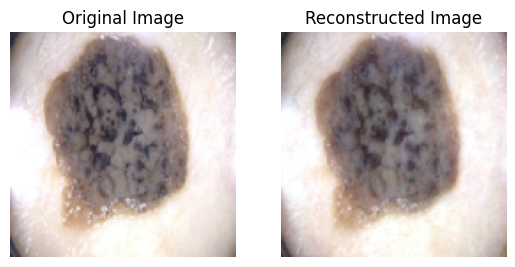

In [10]:
# confront the original image with the reconstructed image for a random image
random_index = np.random.randint(0, len(dataset))
random_image = dataset[random_index].reshape(1, -1)
reconstructed_image = pca.inverse_transform(pca.transform(random_image))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(random_image.reshape(128, 128, 3))
ax[0].set_title('Original Image')
ax[0].axis('off')
reconstructed_image_int = reconstructed_image.astype(int)
ax[1].imshow(reconstructed_image_int.reshape(128, 128, 3))
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')
plt.show()

In [11]:
## save the pca model to a file
#with open('pca.pkl', 'wb') as f:
#    pickle.dump(pca, f)

In [12]:
train = pca.transform(dataset)
df_train = pd.DataFrame(train, index=index)
df_train.index = [ind+"_train" for ind in index]
df_train

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
ISIC_0010093_train,1760.964930,-1856.594366,262.540482,368.470191,-648.666611,-901.814434,-672.753689,1924.292016,-618.532682,895.898979,...,79.436829,-5.700282,28.160735,7.740064,59.971808,25.307130,-9.797735,-11.715771,-24.304811,72.156731
ISIC_0010201_train,143.005611,4427.813033,-928.174388,1811.595792,-201.684735,2486.542260,-2322.463098,1493.330225,-1215.664554,686.415527,...,-28.075436,-36.730495,45.942633,-1.299854,4.407529,-78.948200,45.546588,-4.870447,122.856437,-25.712545
ISIC_0014929_train,6116.776213,-8.693727,104.041932,-2081.073547,2987.602147,-57.913182,598.291825,-1321.322610,2202.134985,-1234.276302,...,157.175793,-50.750264,46.925666,-137.776057,-3.176894,3.020720,-6.182663,83.297839,117.754469,-128.195042
ISIC_0008992_train,2672.292380,-940.171038,2859.836641,535.660131,-425.731691,1621.894580,-348.856837,-338.190161,286.916802,1255.931175,...,-177.262911,15.634935,-17.414774,3.533089,21.066432,105.713925,-52.506748,-47.093279,75.600561,63.035437
ISIC_0012671_train,4058.272212,-601.933062,309.645839,219.537077,1268.695743,226.315077,833.747439,-318.213779,128.988054,-120.599432,...,7.171573,19.338283,-40.161074,10.289032,22.623373,12.175033,-26.702101,-2.382976,-8.832931,-34.681462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0010498_train,4117.030018,1676.958300,369.204920,-1844.691395,2434.178376,-392.966434,774.020116,-445.617809,187.179663,-136.451121,...,32.676925,9.391798,-55.140471,-0.196304,30.720012,-25.315371,-146.903632,53.611442,49.949488,23.507439
ISIC_0010479_train,785.463326,-390.445768,-786.129750,972.958354,-93.940867,-820.612689,691.497298,173.921828,-752.341200,252.091398,...,-37.910883,49.133688,-86.097591,3.231467,29.050938,-111.930603,3.280680,3.389146,5.489788,-45.398403
ISIC_0013783_train,-6381.444667,830.603608,3211.223114,-386.614760,602.927073,402.847296,51.249925,77.483326,-81.270627,598.098604,...,10.888165,-0.172389,-31.218451,-52.534918,-24.624645,131.473849,33.446171,-1.843509,27.221693,1.137418
ISIC_0000364_train,-6983.707743,2980.073033,2420.998054,-5626.872001,-3186.420073,419.543831,-76.017792,-622.245974,1143.947239,-225.185675,...,-95.351947,21.465839,22.532092,26.768034,-20.874296,-81.658738,33.222856,85.254889,55.561745,-29.812812


In [13]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_train, x=0, y=1)
fig.show()

In [29]:
# reduce to 3D
import pacmap
mapper = pacmap.PaCMAP(n_components=2, n_neighbors=2)
X = df_train.values
X_2d = mapper.fit_transform(X)

df_train_2d = pd.DataFrame(X_2d, columns=['x', 'y'], index=df_train.index)
df_train_2d

,x,y
ISIC_0010093_train,-24.932673,-23.697546
ISIC_0010201_train,48.428631,0.252163
ISIC_0014929_train,85.400459,-9.922707
ISIC_0008992_train,-2.806220,5.369605
ISIC_0012671_train,1.646584,6.587116
...,...,...
ISIC_0010498_train,43.579044,23.219273
ISIC_0010479_train,1.165049,-8.866421
ISIC_0013783_train,-13.242702,13.502175
ISIC_0000364_train,-22.576202,-12.254339


In [30]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_train_2d, x='x', y='y')
fig.show()

In [33]:
# reduce dimensionality a second time using UMAP, use 3 dimensions
import umap
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_train)
embedding.shape

df_umap = pd.DataFrame(embedding, index=df_train.index, columns=['x', 'y'])
df_umap

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,x,y
ISIC_0010093_train,4.681847,7.441071
ISIC_0010201_train,4.952336,10.226492
ISIC_0014929_train,2.906013,8.739305
ISIC_0008992_train,4.347092,6.885509
ISIC_0012671_train,3.312281,8.245948
...,...,...
ISIC_0010498_train,3.434827,9.149073
ISIC_0010479_train,5.097752,8.455823
ISIC_0013783_train,9.504599,10.024973
ISIC_0000364_train,7.318337,1.244278


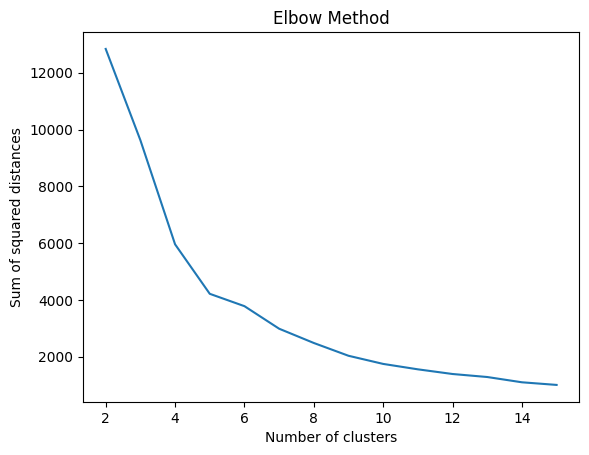

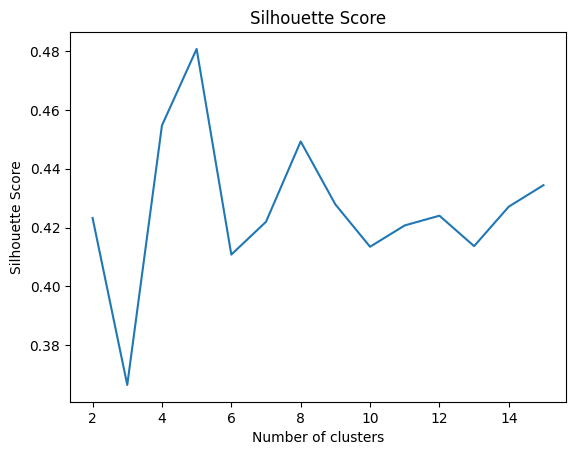

,x,y,cluster
ISIC_0010093_train,4.681847,7.441071,4
ISIC_0010201_train,4.952336,10.226492,3
ISIC_0014929_train,2.906013,8.739305,1
ISIC_0008992_train,4.347092,6.885509,1
ISIC_0012671_train,3.312281,8.245948,1
...,...,...,...
ISIC_0010498_train,3.434827,9.149073,1
ISIC_0010479_train,5.097752,8.455823,4
ISIC_0013783_train,9.504599,10.024973,2
ISIC_0000364_train,7.318337,1.244278,0


In [34]:
# use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# calculate the sum of squared distances for each number of clusters
ssd = []
silhouette = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embedding)
    ssd.append(kmeans.inertia_)
    silhouette.append(silhouette_score(embedding, kmeans.labels_))

# plot the sum of squared distances
plt.plot(range(2, 16), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

# plot the silhouette score
plt.plot(range(2, 16), silhouette)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')   
plt.show()

# use 3 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(embedding)
df_umap['cluster'] = kmeans.labels_
df_umap['cluster'] = df_umap['cluster'].astype(str)
df_umap

In [35]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_umap, x='x', y='y', color='cluster')
fig.show()

In [19]:
import trimap
mapper = trimap.TRIMAP(n_dims=2)
embedding = mapper.fit_transform(df_train)
embedding.shape

df_trimap = pd.DataFrame(embedding, index=df_train.index, columns=['x', 'y'])
df_trimap

,x,y
ISIC_0010093_train,26.090471,-18.762665
ISIC_0010201_train,10.922027,40.969303
ISIC_0014929_train,65.721092,18.303238
ISIC_0008992_train,30.225025,-43.224758
ISIC_0012671_train,50.213970,-16.418413
...,...,...
ISIC_0010498_train,44.867813,17.137650
ISIC_0010479_train,12.996921,-10.722934
ISIC_0013783_train,-75.418747,2.749629
ISIC_0000364_train,-38.489731,87.000450


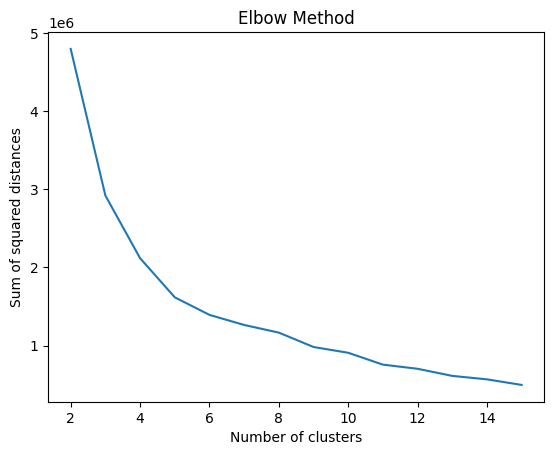

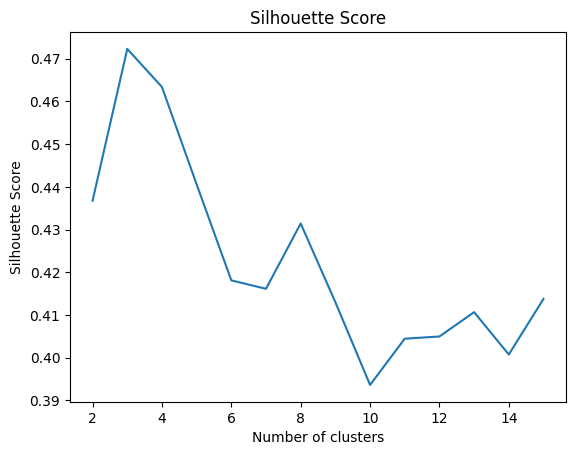

,x,y,cluster
ISIC_0010093_train,26.090471,-18.762665,0
ISIC_0010201_train,10.922027,40.969303,2
ISIC_0014929_train,65.721092,18.303238,0
ISIC_0008992_train,30.225025,-43.224758,0
ISIC_0012671_train,50.213970,-16.418413,0
...,...,...,...
ISIC_0010498_train,44.867813,17.137650,0
ISIC_0010479_train,12.996921,-10.722934,0
ISIC_0013783_train,-75.418747,2.749629,1
ISIC_0000364_train,-38.489731,87.000450,2


In [20]:
# use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# calculate the sum of squared distances for each number of clusters
ssd = []
silhouette = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embedding)
    ssd.append(kmeans.inertia_)
    silhouette.append(silhouette_score(embedding, kmeans.labels_))

# plot the sum of squared distances
plt.plot(range(2, 16), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

# plot the silhouette score
plt.plot(range(2, 16), silhouette)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')   
plt.show()

# use 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(embedding)
df_trimap['cluster'] = kmeans.labels_
df_trimap['cluster'] = df_trimap['cluster'].astype(str)
df_trimap

In [22]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_trimap, x='x', y='y', color='cluster')
fig.show()

In [36]:
df_train.to_csv('train_umap_skincancer.csv')

In [37]:
del df_train

In [38]:
# create a dataset for the test data
output = create_dataset(data_dir_test)

In [39]:
dataset = np.concatenate(output[0], axis=0)
index = output[1]

In [40]:
test = pca.transform(dataset)
df_test = pd.DataFrame(test, index=index)
df_test.index = [ind+"_test" for ind in index]
df_test.to_csv('test_pca.csv')
df_test

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
ISIC_0016028_test,48.050898,-2451.826131,-1546.336999,1548.387749,-1103.467661,340.554373,-77.156353,-737.655857,-504.155840,-15.926256,...,30.122428,-6.120684,-24.308791,-23.313737,13.299975,-11.105736,-24.092538,19.724145,-32.971607,34.892175
ISIC_0014944_test,652.700924,3422.759163,4872.876800,-3210.713537,1534.504980,-1792.528038,2204.782992,-390.340997,-1864.623880,663.617659,...,-13.716717,52.547640,42.332178,29.096653,-15.644368,-21.399348,-15.845669,41.019943,2.840797,-70.064444
ISIC_0015990_test,-5317.752431,-299.399144,-2346.690847,66.320515,1727.649717,10.944313,432.421674,-366.733830,426.211156,-558.123040,...,8.222629,7.677443,4.666242,14.005984,-27.197813,-17.644098,-59.909416,4.651893,37.599925,6.822544
ISIC_0016057_test,-4355.092057,-2234.778813,-1111.603718,465.486620,-23.472028,698.441243,-28.345717,-1124.171006,-915.661385,-196.777581,...,31.371485,3.610811,-32.613094,36.607770,-15.485153,-40.521536,81.237236,-2.274521,17.540704,-40.886064
ISIC_0015089_test,-780.154383,9286.556040,-2947.161367,3032.848498,1614.182482,1925.116880,-4756.729187,-1551.907302,-769.034745,1155.466550,...,-129.154089,57.667734,-63.515600,-87.062989,119.680532,34.682243,-79.403796,-41.990308,-4.469291,-39.168533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0015215_test,5307.826992,892.157181,-358.401748,-1172.981124,1813.466412,-616.123653,-408.933966,-998.287758,335.728136,1062.913336,...,-20.433262,33.841876,7.956231,1.574215,14.410343,22.334505,34.796579,-44.684812,-31.180913,-39.348638
ISIC_0015142_test,-172.767583,3358.379193,-1132.912420,-1799.915724,36.875843,903.845493,-2369.391038,-3972.454060,-43.480890,92.514761,...,-36.437440,-250.155096,151.545374,99.339864,99.970757,15.990734,102.680442,-26.456871,-135.713874,162.851721
ISIC_0016015_test,-3664.624264,-1170.800141,-1879.617057,1457.408262,745.081528,-116.403169,406.334405,-748.188434,217.354717,-540.446556,...,10.408889,-26.784468,1.209587,40.684082,-41.939126,-28.747565,6.592350,-9.674565,-45.247397,-94.489928
ISIC_0012722_test,-5080.505931,-803.080506,3361.603573,-365.349181,800.002006,470.224802,133.976327,-62.043699,-189.287401,29.776097,...,-10.709152,47.768347,-40.199801,-47.285116,-32.448801,37.234580,-35.790367,21.379816,3.918421,-46.261606


In [44]:
df_test_umap = pd.DataFrame(reducer.transform(df_test), index=df_test.index, columns=['x', 'y'])
df_test_umap['cluster'] = kmeans.predict(reducer.transform(df_test))
df_test_umap['cluster'] = df_test_umap['cluster'].astype(str)
df_test_umap

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,x,y,cluster
ISIC_0016028_test,5.235335,7.881536,4
ISIC_0014944_test,6.108692,12.027269,3
ISIC_0015990_test,9.617599,8.008751,2
ISIC_0016057_test,9.185089,8.369471,2
ISIC_0015089_test,4.445866,11.047288,3
...,...,...,...
ISIC_0015215_test,3.184944,8.954462,1
ISIC_0015142_test,5.509278,9.338621,3
ISIC_0016015_test,8.604195,7.838835,2
ISIC_0012722_test,9.184282,9.990444,2


In [46]:
fig = px.scatter(df_test_umap, x='x', y='y', color='cluster')
fig.show()

In [45]:
df_umap_tot = pd.concat([df_umap, df_test_umap])
fig = px.scatter(df_umap_tot, x='x', y='y', color='cluster')
fig.show()

In [47]:
df_test_umap.to_csv('test_umap_skincancer.csv')

In [48]:
del df_test

In [49]:
# create a dataset for the validation data
output = create_dataset(data_dir_val)

In [50]:
dataset = np.concatenate(output[0], axis=0)
index = output[1]
del output

In [51]:
val = pca.transform(dataset)
df_val = pd.DataFrame(val, index=index)
df_val.index = [ind+"_val" for ind in index]
df_val.to_csv('val_pca.csv')
df_val

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
ISIC_0014428_val,2183.026063,-2158.648070,-1378.419227,1420.056640,342.310911,261.902037,-15.393039,-1193.337751,-142.456791,-195.753598,...,62.089230,59.197982,95.068195,18.702893,4.959809,56.909549,21.733692,-43.567347,15.300089,-59.674476
ISIC_0012434_val,2250.093122,-750.442039,1985.138091,978.175979,217.568839,185.224140,138.239080,-423.675652,-1022.110100,551.054016,...,-12.576800,-8.495274,-24.071439,32.538513,-16.342530,-53.409899,-10.461624,6.210631,-5.073334,-8.936891
ISIC_0009995_val,-3171.517766,1257.259616,579.617630,2763.926052,934.013243,992.410067,-1114.167575,1597.394164,-439.329710,83.703460,...,-24.051329,8.063456,43.538524,13.893931,-123.003506,-24.410994,11.469419,-63.246971,111.628689,29.818037
ISIC_0013421_val,-2345.237515,758.953770,-243.625537,231.946302,513.692509,-133.375342,-1085.158978,-856.275787,531.710214,-200.802150,...,1.641725,-1.396827,-43.747878,-14.296414,36.335374,2.934909,57.244003,81.909927,61.389369,-6.451751
ISIC_0014558_val,-4303.999106,210.471797,-570.571033,529.466815,116.942598,485.748366,474.519651,-529.428474,214.017204,554.754761,...,4.984911,36.769699,-41.860570,18.065333,-21.832943,-28.403636,-77.251378,-14.578824,-21.982319,-43.885546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0014688_val,-8711.951829,1209.915028,3363.691200,-436.694173,702.427875,-601.216692,-896.126220,1545.880843,1678.316041,524.868341,...,-48.959655,-185.202810,-13.663605,-92.889774,86.410700,128.886768,-6.628145,12.349289,71.514447,-146.744706
ISIC_0012143_val,-9288.771411,445.220999,-769.271746,1097.201258,858.000031,-333.392015,127.005143,-729.587584,24.854331,-59.927596,...,49.253910,21.240333,16.969430,-39.671348,-1.246283,-13.655042,37.245751,-79.865211,-37.213282,-35.578500
ISIC_0014931_val,-10867.715504,6297.262548,3899.712276,-2426.475859,2492.544288,4165.928814,-1180.416389,-736.636881,-404.153340,-6.692555,...,-128.679158,52.694644,44.597637,19.644281,-81.169592,-62.459940,63.570990,81.935852,86.870645,88.132024
ISIC_0012746_val,-4770.439631,-1146.625998,801.909464,880.886154,169.278432,-174.554891,694.507912,26.824012,-289.958560,-413.514967,...,-80.615140,54.188769,-2.435639,-53.958635,15.768298,11.117177,-41.506565,-27.535169,11.371900,-9.325597


In [52]:
df_val_umap = pd.DataFrame(reducer.transform(df_val), index=df_val.index, columns=['x', 'y'])
df_val_umap['cluster'] = kmeans.predict(reducer.transform(df_val))
df_val_umap['cluster'] = df_val_umap['cluster'].astype(str)
df_val_umap

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,x,y,cluster
ISIC_0014428_val,4.556067,7.795600,4
ISIC_0012434_val,4.238830,6.933949,1
ISIC_0009995_val,7.426929,8.952954,4
ISIC_0013421_val,7.636420,8.790298,4
ISIC_0014558_val,8.769730,8.514374,2
...,...,...,...
ISIC_0014688_val,10.633810,9.844080,2
ISIC_0012143_val,11.406031,9.482998,2
ISIC_0014931_val,7.057032,11.863321,3
ISIC_0012746_val,8.966520,8.918338,2


In [53]:
df_val_umap.to_csv('val_umap_skincancer.csv')